In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

## V1: Batch Normalization is used in hidden layers, for the input layer Standard Normalization is used.

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(120)

        self.fc1 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)

        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):

        x = torch.tanh(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = torch.tanh(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x= torch.tanh(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = torch.tanh(self.bn4(self.fc1(x)))

        x = self.fc2(x)

        x = nn.Softmax(dim=1)(x)
        return x

model_1 = LeNet5()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_1.to(device)


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
transform_train =  transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = (0.1307,), std = (0.3081,))])
transform_test =  transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = (0.1307,), std = (0.3081,))])

trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 71404276.53it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102051974.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 86804541.08it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20288103.05it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.01)

In [ ]:
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
epochs = 20

In [ ]:
def train(epoch, model, trainloader, optimizer, criterion):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 0:
          print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    train_loss /= len(trainloader)
    accuracy = 100.*correct/total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(accuracy)

def test(epoch, model, testloader, optimizer, criterion):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        test_loss /= len(testloader)
        accuracy = 100.*correct/total
        test_loss_list.append(test_loss)
        test_accuracy_list.append(accuracy)


for epoch in range(epochs):
    train(epoch, model_1, trainloader, optimizer, criterion)
    test(epoch, model_1, testloader, optimizer, criterion)


Epoch: 0
0 469 Loss: 2.302 | Acc: 11.719% (15/128)
100 469 Loss: 2.239 | Acc: 37.631% (4865/12928)
200 469 Loss: 2.151 | Acc: 53.976% (13887/25728)
300 469 Loss: 2.078 | Acc: 62.240% (23980/38528)
400 469 Loss: 2.021 | Acc: 67.242% (34514/51328)

Epoch: 1
0 469 Loss: 1.788 | Acc: 86.719% (111/128)
100 469 Loss: 1.756 | Acc: 87.144% (11266/12928)
200 469 Loss: 1.738 | Acc: 87.955% (22629/25728)
300 469 Loss: 1.721 | Acc: 88.512% (34102/38528)
400 469 Loss: 1.707 | Acc: 89.195% (45782/51328)

Epoch: 2
0 469 Loss: 1.644 | Acc: 92.188% (118/128)
100 469 Loss: 1.635 | Acc: 91.770% (11864/12928)
200 469 Loss: 1.626 | Acc: 92.184% (23717/25728)
300 469 Loss: 1.620 | Acc: 92.561% (35662/38528)
400 469 Loss: 1.613 | Acc: 92.910% (47689/51328)

Epoch: 3
0 469 Loss: 1.577 | Acc: 94.531% (121/128)
100 469 Loss: 1.579 | Acc: 94.469% (12213/12928)
200 469 Loss: 1.575 | Acc: 94.691% (24362/25728)
300 469 Loss: 1.572 | Acc: 94.700% (36486/38528)
400 469 Loss: 1.569 | Acc: 94.845% (48682/51328)

Epoch

In [ ]:
print("Final accuracy: ", train_accuracy_list[-1], " Final train loss:", train_loss_list[-1])

Final accuracy:  98.7  Final train loss: 1.4851260307246943


In [ ]:
def plotLossAccuracyGraph(epochs, train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list):
    plt.subplot(2,2,1)
    plt.plot([i for i in range(1, epochs + 1)], train_loss_list)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.subplot(2,2,2)
    plt.plot([i for i in range(1, epochs + 1)], train_accuracy_list)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train Accuracy")
    plt.subplot(2,2,3)
    plt.plot([i for i in range(1, epochs + 1)], test_loss_list)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Test Loss")
    plt.subplot(2,2,4)
    plt.plot([i for i in range(1, epochs + 1)], test_accuracy_list)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Test Accuracy")
    plt.tight_layout()
    plt.show()

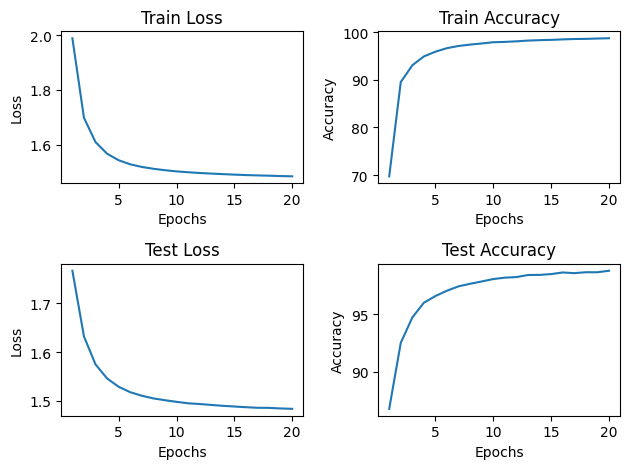

In [ ]:
plotLossAccuracyGraph(epochs, train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list)

In [ ]:
def plotViolitGraphs(model, size):
  fig, axs = plt.subplots(size,2, figsize=(9,9))
  i=0
  for a,b in model.named_modules():
      if(isinstance(b, nn.BatchNorm2d) or isinstance(b, nn.BatchNorm1d)):
          for name, param in b.named_parameters():
              if name in ['weight','bias']:
                  axs[int(i/2), int(i%2)].violinplot(param.detach().cpu().numpy(), vert=True, showmeans=True, showmedians=True)
                  axs[int(i/2), int(i%2)].set_title(f'BatchNorm  {name}, Size ' + str(param.size(dim=0)))

                  i+=1
  plt.tight_layout()
  plt.show()

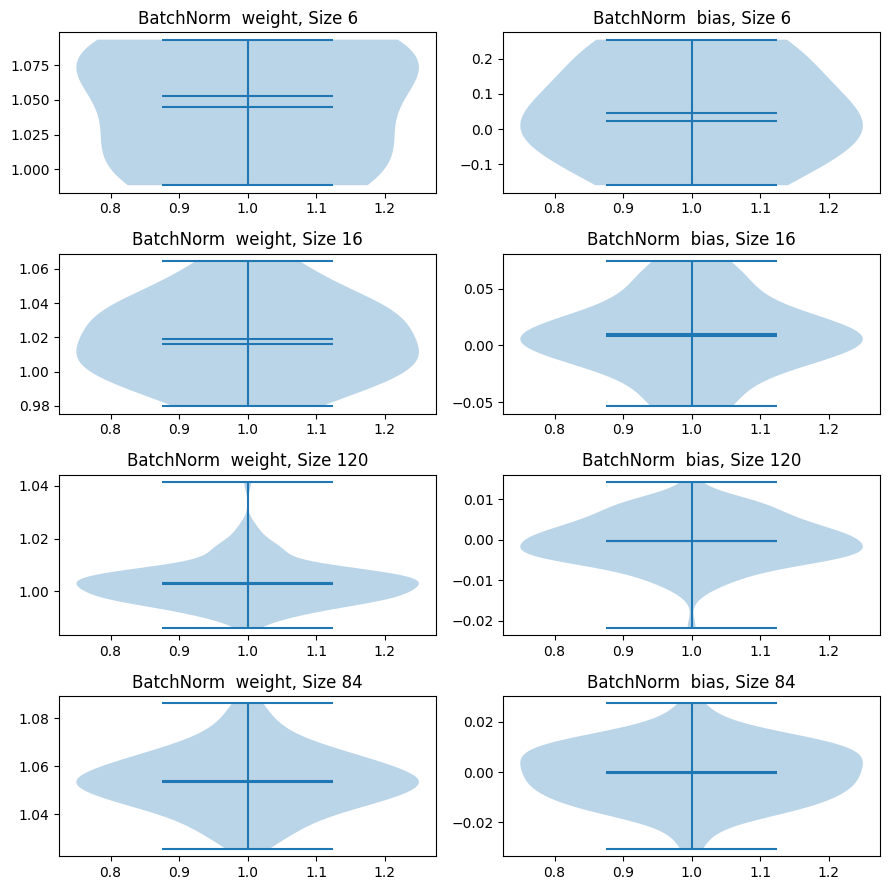

In [ ]:
plotViolitGraphs(model_1, 4)

## V2: Instead of Standard Normalization, Batch Normalization is used for the input layer.

In [ ]:
class LeNet5_v2(nn.Module):
    def __init__(self):
        super(LeNet5_v2, self).__init__()

        self.input_norm = nn.BatchNorm2d(1)

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(120)

        self.fc1 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)

        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.input_norm(x)
        x = torch.tanh(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = torch.tanh(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x= torch.tanh(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = torch.tanh(self.bn4(self.fc1(x)))

        x = self.fc2(x)

        x = nn.Softmax(dim=1)(x)
        return x

model_2 = LeNet5_v2()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_2.to(device)


LeNet5_v2(
  (input_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
transform_train =  transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor()])
transform_test =  transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False, num_workers=4)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

In [ ]:
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
epochs = 20
for epoch in range(epochs):
    train(epoch, model_2, trainloader, optimizer, criterion)
    test(epoch, model_2, testloader, optimizer, criterion)


Epoch: 0
0 469 Loss: 2.313 | Acc: 5.469% (7/128)
100 469 Loss: 2.250 | Acc: 32.704% (4228/12928)
200 469 Loss: 2.173 | Acc: 46.789% (12038/25728)
300 469 Loss: 2.106 | Acc: 55.635% (21435/38528)
400 469 Loss: 2.050 | Acc: 61.736% (31688/51328)

Epoch: 1
0 469 Loss: 1.810 | Acc: 85.156% (109/128)
100 469 Loss: 1.772 | Acc: 87.245% (11279/12928)
200 469 Loss: 1.754 | Acc: 87.395% (22485/25728)
300 469 Loss: 1.737 | Acc: 88.092% (33940/38528)
400 469 Loss: 1.721 | Acc: 88.673% (45514/51328)

Epoch: 2
0 469 Loss: 1.664 | Acc: 91.406% (117/128)
100 469 Loss: 1.645 | Acc: 90.996% (11764/12928)
200 469 Loss: 1.634 | Acc: 91.842% (23629/25728)
300 469 Loss: 1.628 | Acc: 92.016% (35452/38528)
400 469 Loss: 1.622 | Acc: 92.238% (47344/51328)

Epoch: 3
0 469 Loss: 1.570 | Acc: 96.094% (123/128)
100 469 Loss: 1.587 | Acc: 93.588% (12099/12928)
200 469 Loss: 1.583 | Acc: 93.917% (24163/25728)
300 469 Loss: 1.580 | Acc: 94.046% (36234/38528)
400 469 Loss: 1.577 | Acc: 94.262% (48383/51328)

Epoch: 

In [ ]:
print("Final accuracy: ", train_accuracy_list[-1], " Final train loss:", train_loss_list[-1])

Final accuracy:  98.64  Final train loss: 1.4853955598782376


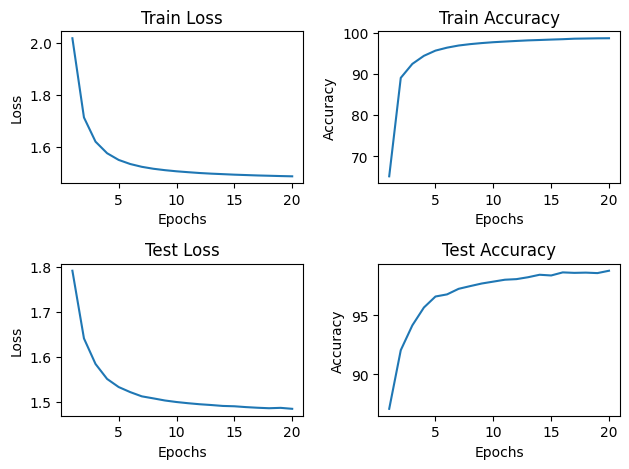

In [ ]:
plotLossAccuracyGraph(epochs, train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list)

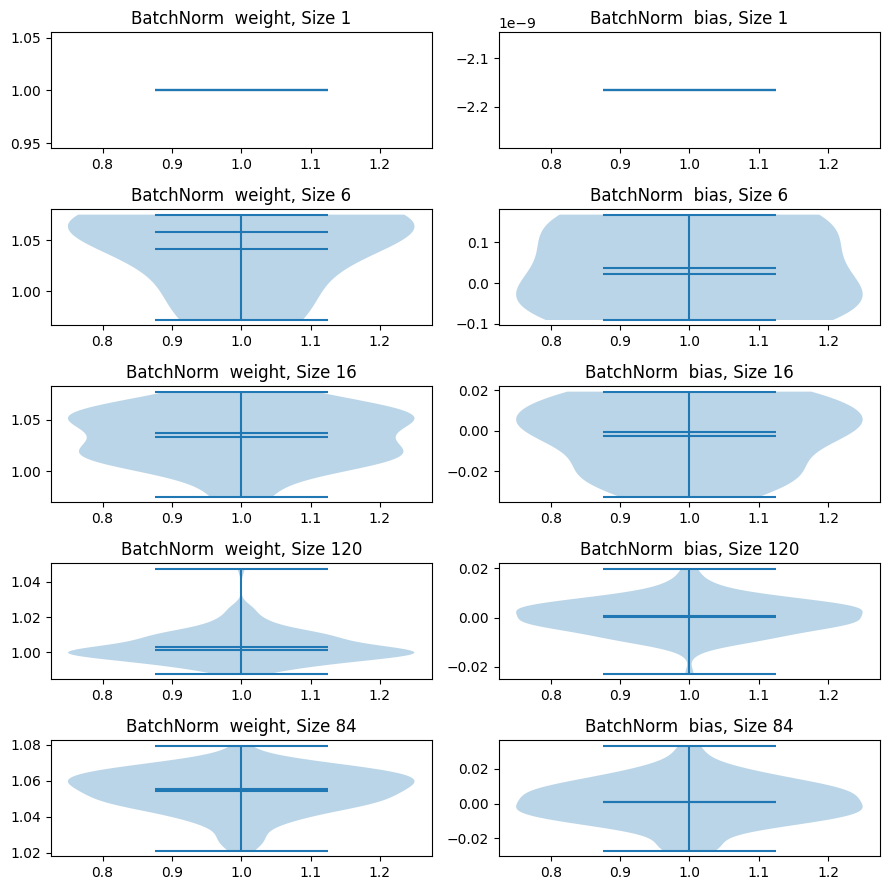

In [ ]:
plotViolitGraphs(model_2, 5)

## V3: Instead of Batch Normalization, DropOut is used.

In [ ]:
class LeNet5_v3(nn.Module):
    def __init__(self):
        super(LeNet5_v3, self).__init__()
        self.dropout1 = nn.Dropout(0.2)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.dropout2 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.dropout3 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)

        self.dropout4 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(120, 84)

        self.dropout5 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.dropout1(x)
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)

        x = self.dropout2(x)

        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)

        x = self.dropout3(x)

        x= torch.tanh(self.conv3(x))

        x = self.dropout4(x)

        x = x.view(x.size(0), -1)

        x = torch.tanh(self.fc1(x))

        x = self.fc2(x)

        x = nn.Softmax(dim=1)(x)
        return x

model_3 = LeNet5_v3()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_3.to(device)

LeNet5_v3(
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (dropout5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
transform_train =  transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor()])
transform_test =  transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False, num_workers=4)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.01)

In [ ]:
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
epochs = 20
for epoch in range(epochs):
    train(epoch, model_3, trainloader, optimizer, criterion)
    test(epoch, model_3, testloader, optimizer, criterion)


Epoch: 0
0 469 Loss: 2.302 | Acc: 14.062% (18/128)
100 469 Loss: 2.303 | Acc: 9.669% (1250/12928)
200 469 Loss: 2.303 | Acc: 9.604% (2471/25728)
300 469 Loss: 2.302 | Acc: 9.666% (3724/38528)
400 469 Loss: 2.302 | Acc: 9.819% (5040/51328)

Epoch: 1
0 469 Loss: 2.302 | Acc: 12.500% (16/128)
100 469 Loss: 2.302 | Acc: 10.914% (1411/12928)
200 469 Loss: 2.302 | Acc: 10.813% (2782/25728)
300 469 Loss: 2.302 | Acc: 10.818% (4168/38528)
400 469 Loss: 2.302 | Acc: 10.846% (5567/51328)

Epoch: 2
0 469 Loss: 2.302 | Acc: 8.594% (11/128)
100 469 Loss: 2.302 | Acc: 11.726% (1516/12928)
200 469 Loss: 2.302 | Acc: 11.524% (2965/25728)
300 469 Loss: 2.302 | Acc: 11.752% (4528/38528)
400 469 Loss: 2.301 | Acc: 11.917% (6117/51328)

Epoch: 3
0 469 Loss: 2.301 | Acc: 10.156% (13/128)
100 469 Loss: 2.301 | Acc: 12.392% (1602/12928)
200 469 Loss: 2.301 | Acc: 12.574% (3235/25728)
300 469 Loss: 2.301 | Acc: 12.882% (4963/38528)
400 469 Loss: 2.301 | Acc: 13.121% (6735/51328)

Epoch: 4
0 469 Loss: 2.300 |

In [ ]:
print("Final accuracy: ", train_accuracy_list[-1], " Final train loss:", train_loss_list[-1])

Final accuracy:  68.05166666666666  Final train loss: 1.8180209311849274


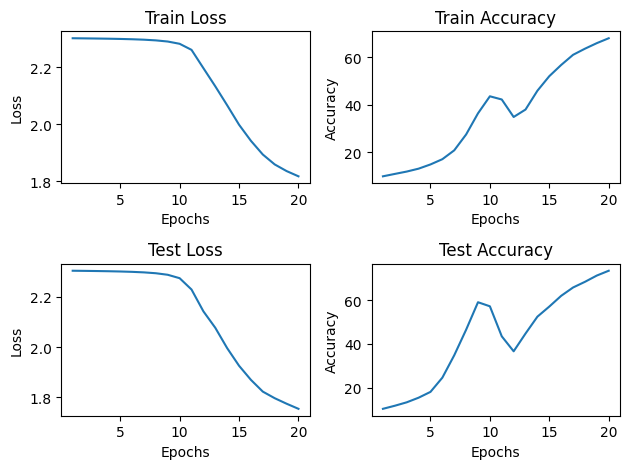

In [ ]:
plotLossAccuracyGraph(epochs, train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list)

## V4: Both Batch Normalization and DropOut are used.

In [ ]:
class LeNet5_v4(nn.Module):
    def __init__(self):
        super(LeNet5_v4, self).__init__()
        self.input_norm = nn.BatchNorm2d(1)
        self.dropout1 = nn.Dropout(0.2)

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.dropout2 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.dropout3 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(120)

        self.dropout4 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)

        self.dropout5 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.input_norm(x)
        x = self.dropout1(x)
        x = torch.tanh(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.dropout2(x)

        x = torch.tanh(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = self.dropout3(x)

        x= torch.tanh(self.bn3(self.conv3(x)))

        x = self.dropout4(x)

        x = x.view(x.size(0), -1)

        x = torch.tanh(self.bn4(self.fc1(x)))

        x = self.dropout5(x)

        x = self.fc2(x)

        x = nn.Softmax(dim=1)(x)
        return x

model_4 = LeNet5_v4()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_4.to(device)

LeNet5_v4(
  (input_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dro

In [ ]:
transform_train =  transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor()])
transform_test =  transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False, num_workers=4)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_4.parameters(), lr=0.01)

In [ ]:
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
epochs = 20
for epoch in range(epochs):
    train(epoch, model_4, trainloader, optimizer, criterion)
    test(epoch, model_4, testloader, optimizer, criterion)


Epoch: 0
0 469 Loss: 2.304 | Acc: 10.156% (13/128)
100 469 Loss: 2.301 | Acc: 11.023% (1425/12928)
200 469 Loss: 2.294 | Acc: 13.495% (3472/25728)
300 469 Loss: 2.286 | Acc: 16.912% (6516/38528)
400 469 Loss: 2.276 | Acc: 20.390% (10466/51328)

Epoch: 1
0 469 Loss: 2.209 | Acc: 45.312% (58/128)
100 469 Loss: 2.195 | Acc: 38.993% (5041/12928)
200 469 Loss: 2.179 | Acc: 40.427% (10401/25728)
300 469 Loss: 2.163 | Acc: 41.811% (16109/38528)
400 469 Loss: 2.148 | Acc: 43.000% (22071/51328)

Epoch: 2
0 469 Loss: 2.091 | Acc: 47.656% (61/128)
100 469 Loss: 2.061 | Acc: 49.126% (6351/12928)
200 469 Loss: 2.049 | Acc: 50.128% (12897/25728)
300 469 Loss: 2.038 | Acc: 51.225% (19736/38528)
400 469 Loss: 2.027 | Acc: 52.172% (26779/51328)

Epoch: 3
0 469 Loss: 1.958 | Acc: 60.938% (78/128)
100 469 Loss: 1.971 | Acc: 57.201% (7395/12928)
200 469 Loss: 1.961 | Acc: 57.968% (14914/25728)
300 469 Loss: 1.952 | Acc: 58.648% (22596/38528)
400 469 Loss: 1.944 | Acc: 59.219% (30396/51328)

Epoch: 4
0 46

In [ ]:
print("Final accuracy: ", train_accuracy_list[-1], " Final train loss:", train_loss_list[-1])

Final accuracy:  82.09166666666667  Final train loss: 1.6769550433799403


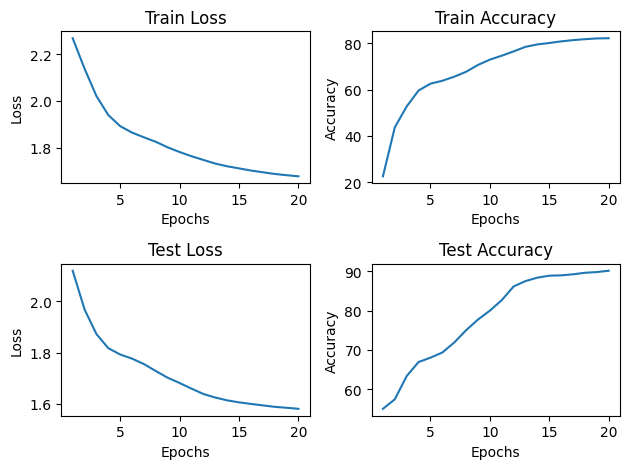

In [ ]:
plotLossAccuracyGraph(epochs, train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list)

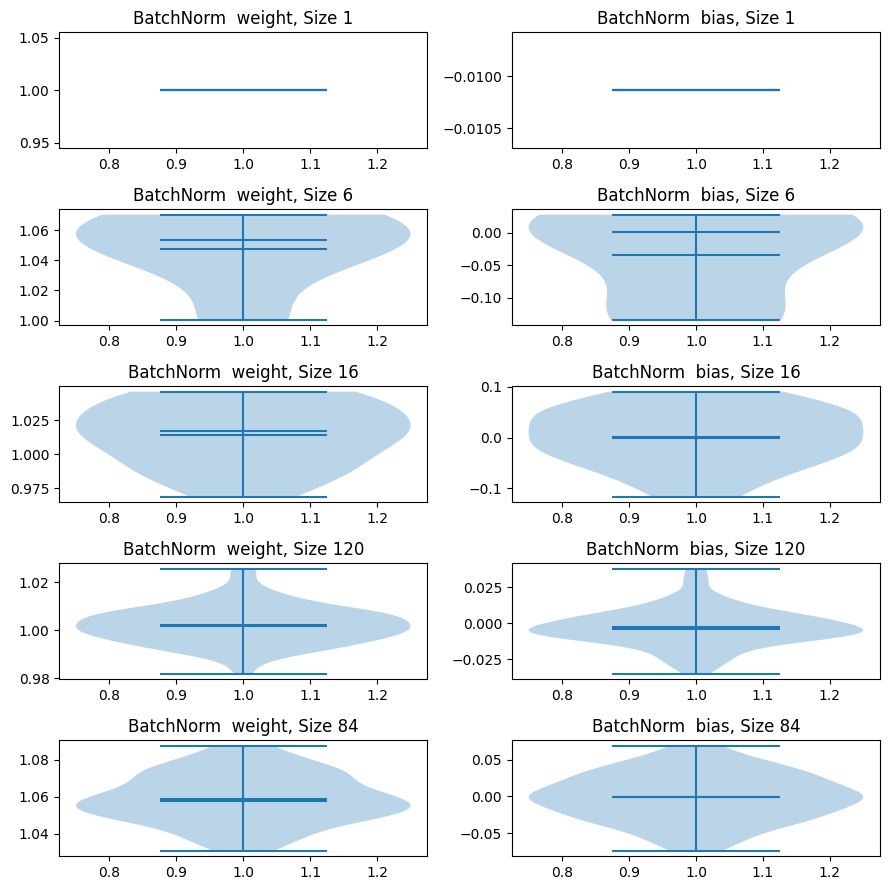

In [ ]:
plotViolitGraphs(model_4, 5)